In [3]:
import os
import sys
import numpy as np
import tensorflow as tf
import random
import math
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import copy
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import glob
from zipfile import ZipFile 

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
# from torcheval.metrics.functional import binary_auroc
import torch.nn.functional as F

import time
import gc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# For Image Models
import timm

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# For descriptive error messages
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

c:\Users\haric\anaconda3\envs\aneamia\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
CONFIG = {
    "seed": 42,
    "image_size": 384,
    "grid_dim": 12,
    "mask_count": 1,
    "max_bbox_count": 2,
    "epochs": 25,
    "train_batch_size": 16,
    "valid_batch_size": 16,
    "learning_rate": 1e-4,
    "min_lr": 1e-6,
    "weight_decay": 1e-6,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])



TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'


img_width = CONFIG["image_size"]
img_height = CONFIG["image_size"]

grid_dim = CONFIG['grid_dim']
grid_pix = img_width // grid_dim

batch_size = CONFIG['train_batch_size']

mask_count = CONFIG['mask_count']
#Set maximum bounding boxes allowed per grid cell
max_bbox_count = CONFIG['max_bbox_count']


print(img_width, grid_dim, grid_pix, batch_size, mask_count, max_bbox_count)

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

train_images = np.zeros((len(train_ids), img_height, img_width, 3), dtype=np.uint8)
test_images = np.zeros((len(test_ids), img_height, img_width, 3), dtype=np.uint8)

# Resize train images.
print('resize train images... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :3]
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)

    train_images[n] = img

print('Done!')


NameError: name 'torch' is not defined

In [11]:
len(train_ids), len(train_images)

(670, 670)

In [12]:
def store_bounding_boxes(img, train_id, mask_id, rotby_90):
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours, _ = cv2.findContours(thresh.astype(np.uint8), 1, 2)
    cnt = contours[0]
#     print(cv2.boundingRect(cnt))
    x, y, w, h = cv2.boundingRect(cnt)    
    
    x = x * (img_width/img.shape[1])
    w = w * (img_width/img.shape[1])
    y = y * (img_width/img.shape[0])
    h = h * (img_width/img.shape[0])
    
    if(x > img_width-1):
        x = img_width-1
    if(y > img_height-1):
        y = img_height-1
    if(x+w > img_width-1):
        w = img_width-1 - x
    if(y+h > img_height-1):
        h = img_height-1 - y
        
    bbdict = { "train_id": train_id, "mask_id": mask_id, "rotby_90": rotby_90, "x": x, "y": y, "w": w, "h": h}
    return bbdict

In [13]:
path_bboxes_csv = 'train_labels.csv'
if not os.path.isfile(path_bboxes_csv):
    bboxes = pd.DataFrame(columns=["train_id", "mask_id", "rotby_90", "x", "y", "w", "h"])
    row_count = 1
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + "/" + id_
        for mask_id, mask_file in enumerate(next(os.walk(path + '/masks/'))[2]):
            mask_ = imread(path + '/masks/' + mask_file)
    #         print(mask_[9])
            for r in range(4):
                bboxes.loc[row_count] = store_bounding_boxes(np.rot90(mask_, r), id_, mask_id, r)
                row_count += 1
    bboxes.to_csv('bboxes.csv', index=False)
else:
    bboxes = pd.read_csv(path_bboxes_csv)

100%|██████████| 670/670 [12:02<00:00,  1.08s/it]


In [14]:
train_ids_df.head()

NameError: name 'train_ids_df' is not defined

In [15]:
bboxes['grid_row'] = bboxes['y'] // grid_pix
bboxes['grid_column'] = bboxes['x'] // grid_pix

bboxes['grid_center_x'] = bboxes['grid_column'] * grid_pix + grid_pix/2
bboxes['grid_center_y'] = bboxes['grid_row'] * grid_pix + grid_pix/2

bboxes['box_center_x'] = bboxes.x + bboxes['w']/2
bboxes['box_center_y'] = bboxes.y + bboxes['h']/2

bboxes['new_x'] = (bboxes.box_center_x - bboxes.grid_center_x)/(img_width)
bboxes['new_y'] = (bboxes.box_center_y - bboxes.grid_center_y)/(img_height)

bboxes['new_w'] = np.sqrt(bboxes.w/(img_width))
bboxes['new_h'] = np.sqrt(bboxes.h/(img_width))

bboxes['confidence'] = 1

bboxes['box_area'] = bboxes.new_w*bboxes.new_h

In [16]:
bboxes.isnull().values.any()

False

In [17]:
def get_grid_info(tr_id, rotby_90):
    df = bboxes.loc[(bboxes.train_id == tr_id) & (bboxes.rotby_90 == rotby_90), 'grid_row':'box_area']
    df.drop(['grid_center_x', 'grid_center_y','box_center_x', 'box_center_y',], axis = 1, inplace=True)
    df = df.sort_values(['grid_column', 'grid_row', 'box_area'], ascending=False)
    #print(len(df))
    global mask_count
    mask_count += len(df)
    label_info = np.zeros(shape=(grid_dim, grid_dim, max_bbox_count, 5),  dtype=np.float32) + 0.000001
    
    for ind, row in df.iterrows():
        i = int(row[0])
        j = int(row[1])
        for b in range(max_bbox_count):
            if(label_info[i, j, b][4] != 1.0):
                label_info[i, j, b] = np.array(row[2:7])
                break
    return label_info

In [18]:
def draw_bboxes(img, bbs1):
    print(img.shape)
    f, axs = plt.subplots(1,2)
    axs[0].imshow(img)
    for i, b in enumerate(bbs1):
        cv2.rectangle(img,(b[0], b[1]),(b[2], b[3]),(0,255,0),2)

    axs[1].imshow(img)

In [19]:
def draw_data(img, boxes1, thresh):
    print(boxes1.shape)
#     boxes1 = boxes1.cpu()
    boxes1 = np.reshape(boxes1, newshape=[grid_dim, grid_dim, max_bbox_count, 5])
    bbs1 = []

    for i in range(grid_dim):
        for j in range(grid_dim):
            for b in range(max_bbox_count):
                if(boxes1[i][j][b][4] > thresh):
    #                 print('boxes1[i][j][b][4] == boxes2[i][j][b][4]:', boxes1[i][j][b][4])

                    grid_center_x = ((j+0)*grid_pix + grid_pix/2)
                    grid_center_y = ((i+0)*grid_pix + grid_pix/2)
    #                 print(boxes1[i][j][b] == boxes2[i][j][b])

                    new_box_center_x = boxes1[i][j][b][0] * img_width + grid_center_x
                    new_box_center_y = boxes1[i][j][b][1] * img_height + grid_center_y

                    new_w = np.square(boxes1[i][j][b][2]) * img_width
                    new_h = np.square(boxes1[i][j][b][3]) * img_height

                    x1 = new_box_center_x - new_w/2
                    y1 = new_box_center_y - new_h/2

                    x2 = new_box_center_x + new_w/2
                    y2 = new_box_center_y + new_h/2

                    bbs1.append((math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)))
                    
    draw_bboxes(img, bbs1)

In [20]:
# To build a custom dataset in PyTorch without downloading images:
# Initialize the class with the necessary arguments, such as the list of image paths, labels, and transformations.
# Implement the __len__ method to return the number of samples in the dataset.
# Implement the __getitem__ method to return a single sample (image and label) from the dataset.

import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class TrainDataset(Dataset):
    def __init__(self, train_images, train_ids, transform=None):
        self.train_images = train_images
        self.train_ids = train_ids
        self.transform = transform

    def __len__(self):
        return len(self.train_images)

    def __getitem__(self, index):
#         print('index', index)
        rotation = random.randint(0, 3)
        img = self.__get_image(index, rotation)
        label = self.__get_label(index, rotation)
#         print('index', index)
#         print('dataset image and label shapes', img.shape, label.shape)
        return {
            'image': img,
            'label': label
        }
    
    def __get_image(self, index, rotation):
        image = np.rot90(self.train_images[index], rotation)
#         image = train_images[index]
        image = torch.from_numpy(image.copy())
        return image

    def __get_label(self, index, rotation):
        grid_info = get_grid_info(train_ids[index], rotation)
        label = torch.from_numpy(grid_info)
        return label

In [21]:
train_dataset = TrainDataset(train_images=train_images, train_ids=train_ids)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                          num_workers=0, shuffle=True, pin_memory=True, drop_last=True)

(12, 12, 2, 5)
(384, 384, 3)


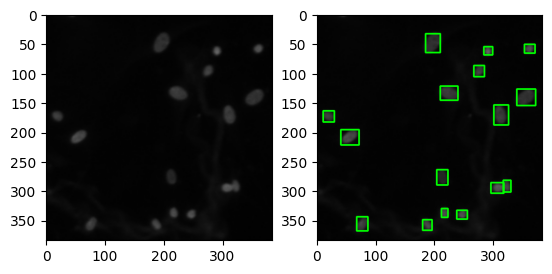

In [22]:
data = next(iter(train_dataloader))
image = data['image'][0].numpy().copy()
label = data['label'][0].numpy().copy()

draw_data(image, label, thresh=0.1)

In [23]:
len(train_dataloader)

41

In [24]:
def normalize_yolo_loss(y_pred, labels):
    lambda_coords = 5.0
    lambda_noobj = 0.5

    # Compute squared difference between predictions and labels
    yolo_loss = torch.sum(torch.square(labels - y_pred), dim=0)
    yolo_loss = torch.sum(yolo_loss, dim=0)
    yolo_loss = torch.sum(yolo_loss, dim=0)
    yolo_loss = torch.sum(yolo_loss, dim=0)
#     print('yolo loss before stacking', yolo_loss)
    
    # Separate the loss components and apply the appropriate lambda weights
    yolo_loss = torch.stack([
        lambda_coords * yolo_loss[0],
        lambda_coords * yolo_loss[1],
        yolo_loss[2],
        yolo_loss[3],
        lambda_noobj * yolo_loss[4]
    ])
#     print('yolo loss before final loss', yolo_loss)
    
    # Sum the losses to get the total loss
    yolo_loss = torch.sum(yolo_loss)
#     print('final yolo loss', yolo_loss)

    return yolo_loss

In [25]:
class YoloLogitsLayer(nn.Module):
    def __init__(self):
        super(YoloLogitsLayer, self).__init__()
        self.avg_pool_3d = nn.AvgPool3d((1, 1, 16), stride=(1, 1, 16), padding=0)
        self.grid_dim = 12
        self.max_bb_cnt = 2

    def forward(self, inputs):
#         print(inputs.shape)
        net = inputs.reshape(-1, 1, self.grid_dim, self.grid_dim, self.max_bb_cnt * 5 * 16)
#         print(f"input shape before avg 3d pool {net.shape}")
        net = self.avg_pool_3d(net)
#         print(f"input shape after avg 3d pool {net.shape}")
        net = net.permute(0, 2, 3, 4, 1)
        net = net.reshape(-1, self.grid_dim * self.grid_dim * self.max_bb_cnt, 5)
#         print(f"input shape after second reshape {net.shape}")

        net = net.permute(1, 2, 0)
#         print('before stacking:', net.shape)
#         logits_tensor = stack_logits(net)
#         logits_tensor = torch.stack([stack_logits(x) for x in net])
#         print(f"input shape before stacking {net.shape}")

        logits_tensor = torch.stack([
            torch.tanh(net[:, 0]),
            torch.tanh(net[:, 1]),
            torch.sqrt(torch.sigmoid(net[:, 2])),
            torch.sqrt(torch.sigmoid(net[:, 3])),
            torch.sigmoid(net[:, 4])
        ], dim=1)
#         print('after stacking:', net.shape)
#         print(f"input shape before last permute {logits_tensor.shape}")

        logits_tensor = logits_tensor.permute(2, 0, 1)
#         print(f"input shape after last permute {logits_tensor.shape}")

        logits_tensor = logits_tensor.reshape(-1, self.grid_dim, self.grid_dim, self.max_bb_cnt, 5)
#         print(f"input shape after last reshape {logits_tensor.shape}")
        return logits_tensor

In [26]:
class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(FireModule, self).__init__()
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1, padding='same')
        self.expand1 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1, padding='same')
        self.expand3 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3, padding='same')
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
#         self.batch_norm = v

    def forward(self, x):
#         print(f'Fire module forward: x.shape: {x.shape}')
        squeeze = self.leaky_relu(self.squeeze(x))
        expand1 = self.leaky_relu(self.expand1(squeeze))
        expand3 = self.leaky_relu(self.expand3(squeeze))
#         print('expand 1 and 3 shapes', expand1.shape, expand3.shape)
        
        return torch.cat([expand1, expand3], 1)

    
class PermuteLayer(nn.Module):
    def __init__(self, *dims):
        super(PermuteLayer, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

    
class YoloModel(nn.Module):
    def __init__(self):
        super(YoloModel, self).__init__()
        self.logits_layer = YoloLogitsLayer()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, stride=1, padding='same'),
            nn.LeakyReLU(negative_slope=0.1),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            FireModule(32, 32, 64),
            FireModule(128, 32, 64),
            FireModule(128, 32, 64),

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            FireModule(128, 64, 96),
            FireModule(192, 64, 96),
            FireModule(192, 64, 96),

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            FireModule(192, 128, 160),
            FireModule(320, 128, 160),
            FireModule(320, 128, 128),

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            FireModule(256, 256, 512),
            FireModule(1024, 256, 512),
            FireModule(1024, 256, 512),

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            FireModule(1024, 512, 1024),
            FireModule(2048, 512, 1024),
            FireModule(2048, 512, 1024),

            nn.Conv2d(2048, max_bbox_count*5*16, kernel_size=1, stride=1, padding='same')
        )
        
    def forward(self, x):
#         print('shape before first permute', x.shape)
        x = x.permute((0, 3, 1, 2))
#         print('shape after first permute', x.shape)
        x = self.model(x)
#         print('shape before second permute', x.shape)
        x = x.permute((0, 2, 3, 1))
#         print('shape after second permute', x.shape)
        x = self.logits_layer(x)
#         print('shape after logits layer', x.shape)
        return x

# Model initialization
model = YoloModel()

# # Initialize the model, loss function, and optimizer
# model = SqueezeNet(3, max_bbox_count*16*5) # 3 - no of image color channels
# x = x.to(memory_format=torch.channels_last)
model = model.to(CONFIG['device'])

In [27]:
model.state_dict

<bound method Module.state_dict of YoloModel(
  (logits_layer): YoloLogitsLayer(
    (avg_pool_3d): AvgPool3d(kernel_size=(1, 1, 16), stride=(1, 1, 16), padding=0)
  )
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): FireModule(
      (squeeze): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (4): FireModule(
      (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (leaky_relu): LeakyReLU

In [28]:
total_params = sum(p.numel() for p in model.parameters())

print(total_params)

24181760


In [29]:
def criterion(y_pred, y_true):
    return normalize_yolo_loss(y_pred, y_true)

In [30]:
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

In [31]:
def train_epoch(model, optimizer, dataloader, device, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    train_loss = 0.0
    epoch_done = epoch
    batch_size = 16
    num_samples_per_epoch = (len(dataloader)//batch_size) * batch_size
    
    batch_size = CONFIG['train_batch_size']
    bar = tqdm(enumerate(dataloader), total=len(dataloader))

    for train_step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.float)
        
        outputs = model(images)

        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()

        train_loss = running_loss / (train_step+1)
                
        bar.set_postfix(epoch=f"{epoch}/{num_epochs}", loss ='{: .4f}'.format(train_loss), learning_rate='{: .4f}'.format(optimizer.param_groups[0]['lr']))
    
    return train_loss

In [32]:
def run_training(model, optimizer, device, num_epochs, scheduler):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    start = time.time()
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        
        epoch_loss = train_epoch(model=model, optimizer=optimizer, dataloader=train_dataloader, 
                                      device=CONFIG['device'], epoch=epoch, 
                                      num_epochs=num_epochs)
        
        history['train_loss'].append(epoch_loss)
#         bar.set_postfix(epoch=f"{epoch}/{num_epochs}", loss ='{: .4f}'.format(train_loss),
#                         learning_rate='{:.4f}'.format(optimizer.param_groups[0]['lr']))
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    return history

In [33]:
model.state_dict

<bound method Module.state_dict of YoloModel(
  (logits_layer): YoloLogitsLayer(
    (avg_pool_3d): AvgPool3d(kernel_size=(1, 1, 16), stride=(1, 1, 16), padding=0)
  )
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): FireModule(
      (squeeze): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (4): FireModule(
      (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (expand3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (leaky_relu): LeakyReLU

In [34]:
# optimizer

In [36]:
history = run_training(model=model, optimizer=optimizer,
                              device=CONFIG['device'],
                              num_epochs=500, scheduler=None)

100%|██████████| 41/41 [07:19<00:00, 10.71s/it, epoch=5/5, learning_rate=0.0001, loss=357.3783]

Training complete in 0h 42m 16s


In [37]:
torch.save(model.state_dict(), 'yolo_model.pth')

In [38]:
history_len = len(history["train_loss"])

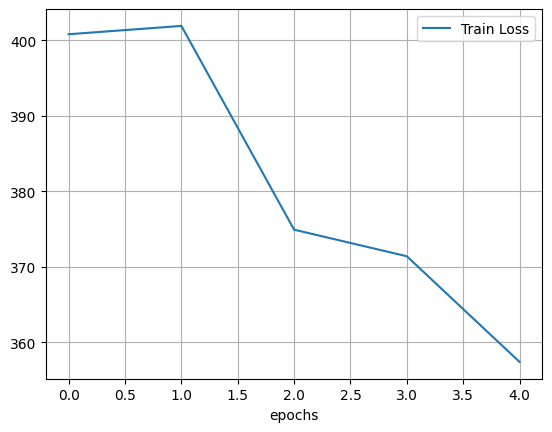

In [39]:
plt.plot(range(history_len), history["train_loss"], label="Train Loss")
# plt.plot(range(history_len), history["learning_rate"], label="Learning Rate")
plt.xlabel("epochs")
# plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [40]:
#Get and resize test images
sizes_test = []
print('resize test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    test_images[n] = img

resize test images ... 


100%|██████████| 65/65 [00:03<00:00, 18.57it/s]


In [41]:
test_img = test_images[1].copy()
test_img = torch.from_numpy(test_img).float().to(CONFIG['device'])
test_img = torch.unsqueeze(test_img, dim = 0)
# print(test_img.shape)
model.eval()
with torch.inference_mode():
    result = model(test_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


torch.Size([12, 12, 2, 5])
(384, 384, 3)


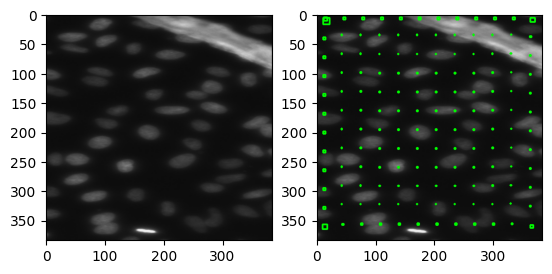

In [42]:
# test_img = test_img
pred_boxes = result[0].cpu()
test_img = test_img.cpu().numpy()
# print(type(test_img))
draw_data(test_img.squeeze()/255., pred_boxes, thresh=0.1)